In [118]:
import sys
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.signal import sosfiltfilt, butter
import logging
import scipy as sp
import matplotlib.pyplot as plt
from deepmeg.data.datasets import EpochsDataset
from deepmeg.preprocessing.transforms import one_hot_encoder
import deepmeg.preprocessing.transforms as transforms

In [25]:
plt.set_loglevel('ERROR')

stream_handler = logging.StreamHandler(sys.stdout)
stream_handler.setFormatter(logging.Formatter("%(asctime)s - %(levelname)s - %(message)s"))

logging.basicConfig(
    level=logging.ERROR,
    handlers=[stream_handler]
)

In [77]:
def plot_distribution(data: list[int | float], title: str = '', xlabel: str = 'Data', ylabel: str = 'Frequency', bins: int = 30) -> plt.Figure:
    """
    Plot the distribution of data.

    Args:
        data (array-like): The data to be plotted.
        title (str): The title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        bins (int, optional): Number of bins for the histogram. Defaults to 30.
    """
    plt.hist(data, bins=bins, alpha=0.7, color='b')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    return fig


def zscore(matrix: np.ndarray, axis: int = 0) -> np.ndarray:
    """
    Calculate the z-scores of a matrix along the specified axis.

    Args:
        matrix (numpy.ndarray): The input matrix.
        axis (int, optional): The axis along which to calculate the z-scores. Defaults to 0.

    Returns:
        numpy.ndarray: The matrix with z-scores along the specified axis.
    """
    mean = np.mean(matrix, axis=(0, 1), keepdims=True)
    std = np.std(matrix, axis=(0, 1), keepdims=True)
    normalized_matrix = (matrix - mean) / std
    return normalized_matrix


def preprocess_gaze(
    gaze_path: str,
    info_path: str,
    fmin: float = 0.1,
    fmax: float = 3,
    fs: int = 61,
    f_order: int = 4,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Analyze gaze gaze and extract relevant information.

    Args:
        gaze_path (str): Path to the gaze data CSV file.
        info_path (str): Path to the info data CSV file.
        fmin (float, optional): Minimum frequency for bandpass filter. Defaults to 0.1.
        fmax (float, optional): Maximum frequency for bandpass filter. Defaults to 3.
        fs (int, optional): Sampling frequency. Defaults to 61.
        f_order (int, optional): Order of the filter. Defaults to 4.

    Returns:
        tuple: A tuple containing time_series and ar_val. ar_val[:, 0] = arousal, ar_val[:, 1] = valence
    """

    logging.debug("Loading gaze and info data...")
    gaze = pd.read_csv(gaze_path)
    info = pd.read_csv(info_path)

    gaze_time_col = [col for col in gaze.columns if col.startswith('TIME(')][0]
    gaze_start = datetime.strptime(gaze_time_col[5:-1], '%Y/%m/%d %H:%M:%S.%f')
    img_start = datetime.strptime(info.start_time_system[0], '%d/%m/%y %H:%M:%S.%f')

    time_difference = abs((img_start.timestamp() - gaze_start.timestamp()) * 1000)
    if time_difference > 1_000_000:
        raise ValueError('Time difference between start of recording and image presentation is too large')

    fs = gaze.CNT.iloc[-1] / gaze[gaze_time_col].iloc[-1]
    counter = (
        np.array(
            info.time_Images[1::2] - ( ( img_start.timestamp() - gaze_start.timestamp() ) * 1000 )
        ) / 1000 * fs
    ).astype(int)

    arousal = np.array(info.form_response[1::2]).astype(int)
    valence = np.array(info.form_response[2::2]).astype(int)

    logging.debug("Interpolating missing data in gaze...")
    to_interpolate = ['FPOGX', 'FPOGY', 'LPMM', 'RPMM', 'GSR', 'HR']
    gaze[to_interpolate] = gaze[to_interpolate].interpolate(method='linear', axis=0)

    logging.debug("Calculating derived columns...")
    gaze['ep_begin'] = np.zeros(len(gaze))
    gaze['ep_begin'][counter] = 1
    gaze = gaze
    gaze['mean_PMM'] = (gaze.LPMM + gaze.RPMM) / 2
    gaze.mean_PMM = gaze.mean_PMM.rolling(window=10, min_periods=0, center=True).mean()
    gaze.GSR = gaze.GSR.rolling(window=100, min_periods=0, center=True).mean()

    logging.debug("Applying bandpass filter to GSR...")
    low = fmin / (fs / 2)
    high = fmax / (fs / 2)
    sos = butter(f_order, [low, high], btype='bandpass', output='sos')
    gaze.GSR = sosfiltfilt(sos, gaze.GSR)
    gaze.HR = gaze.HR.rolling(window=100, min_periods=0, center=True).mean()

    logging.debug("Extracting epoch information...")
    idx = np.where(gaze.ep_begin == 1)[0]
    ns = len(idx)
    t_range = 300
    vars_ = ['FPOGX', 'FPOGY', 'mean_PMM', 'GSR', 'HR']

    time_series = np.zeros((ns, t_range, len(vars_)))
    ar_val = np.zeros((ns, 2))
    ar_val[:, 0] = arousal
    ar_val[:, 1] = valence

    for n, i in enumerate(idx[1:-1]):
        time_series[n] = np.array(gaze[vars_][i:(i + t_range)])

    logging.info(f'NaN count in time_series: {np.isnan(time_series).sum()}')

    return time_series, ar_val

In [90]:
ts, labels = preprocess_gaze(
    '/home/user/Downloads/User 0_all_gaze.csv',
    '/home/user/Downloads/subject-0.csv',
)

2023-08-05 12:45:33,158 - DEBUG - Loading gaze and info data...
2023-08-05 12:45:34,150 - DEBUG - Interpolating missing data in gaze...
2023-08-05 12:45:34,160 - DEBUG - Calculating derived columns...
2023-08-05 12:45:34,174 - DEBUG - Applying bandpass filter to GSR...
2023-08-05 12:45:34,186 - DEBUG - Extracting epoch information...


/tmp/ipykernel_3598388/2510103614.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1


2023-08-05 12:45:35,061 - INFO - NaN count in time_series: 0


/home/user/Projects/oasisnn/venv/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


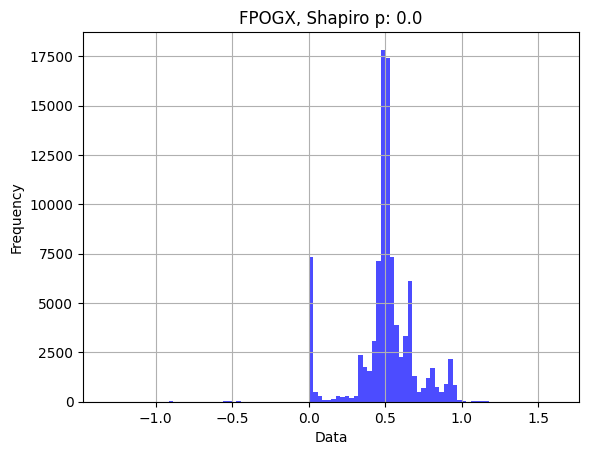

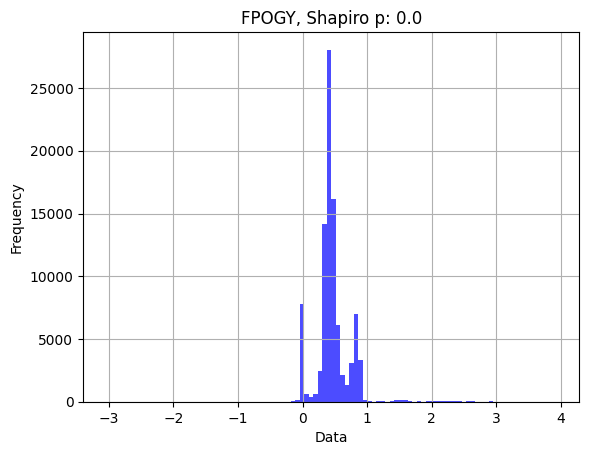

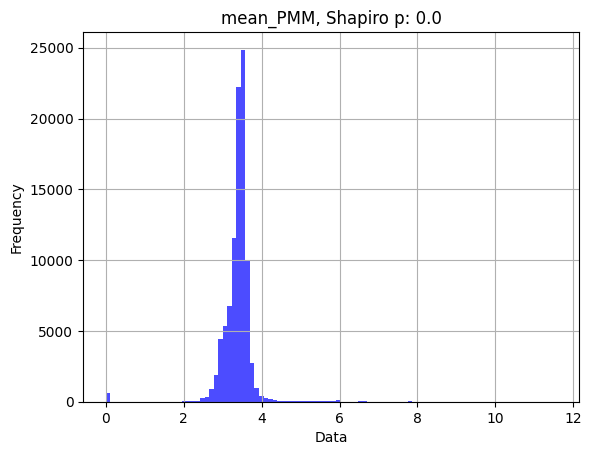

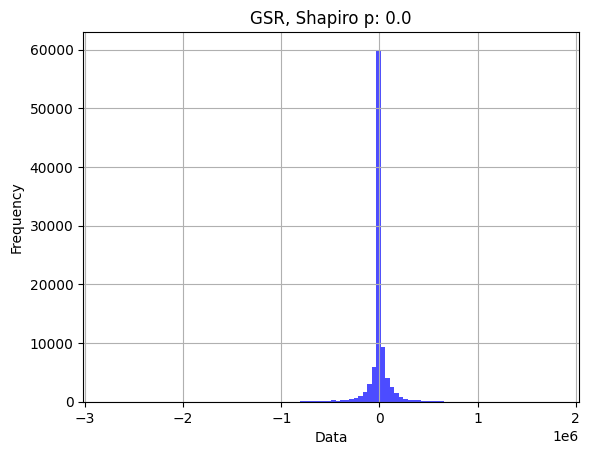

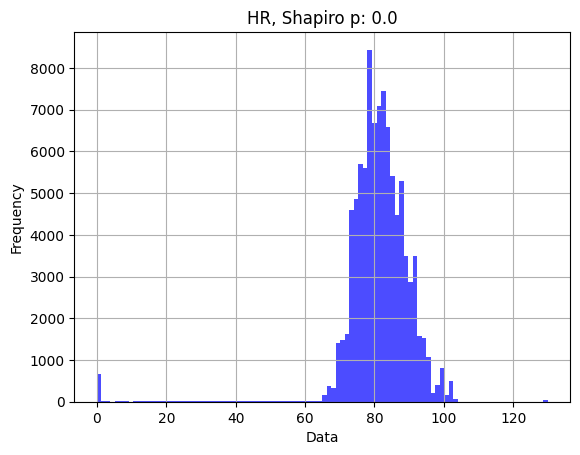

In [79]:
for i, feat_name in enumerate(['FPOGX', 'FPOGY', 'mean_PMM', 'GSR', 'HR']):
    data = np.reshape(ts[:, :, i], -1)
    fig = plot_distribution(data, title=f'{feat_name}, Shapiro p: {sp.stats.shapiro(data).pvalue}', bins=100)
    plt.show()

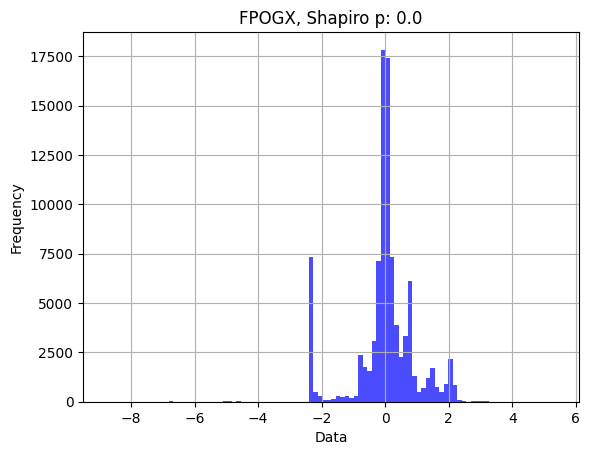

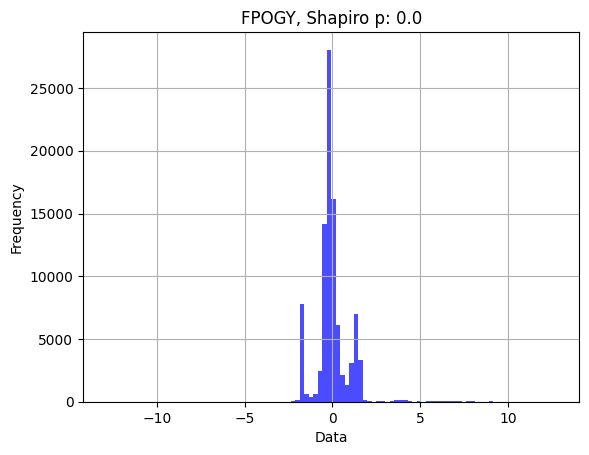

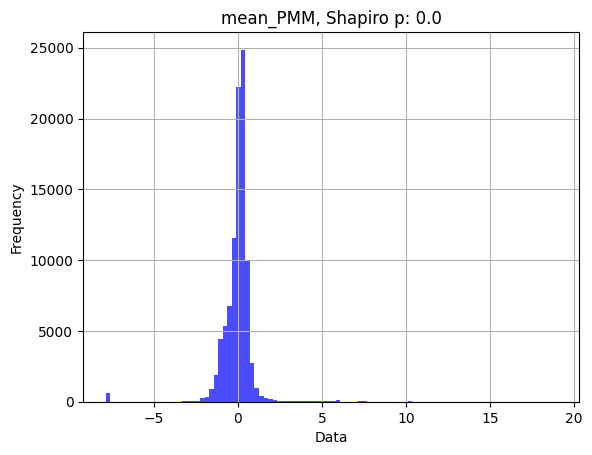

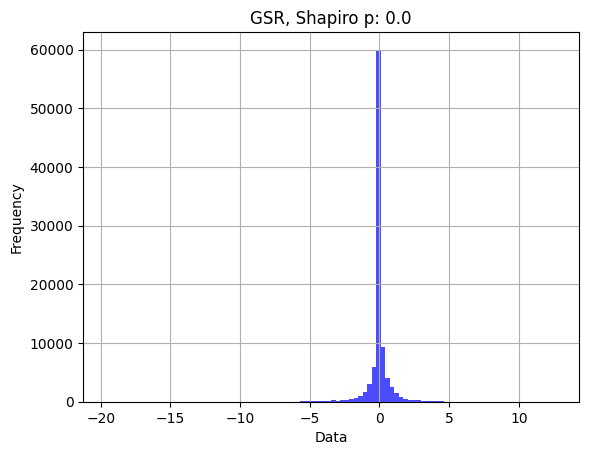

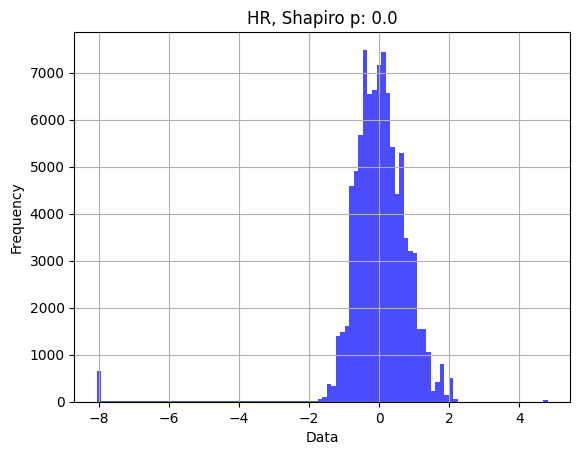

In [104]:
ts = zscore(ts, axis=(0, 1))

for i, feat_name in enumerate(['FPOGX', 'FPOGY', 'mean_PMM', 'GSR', 'HR']):
    data = np.reshape(ts[:, :, i], -1)
    fig = plot_distribution(data, title=f'{feat_name}, Shapiro p: {sp.stats.shapiro(data).pvalue}', bins=100)
    plt.show()

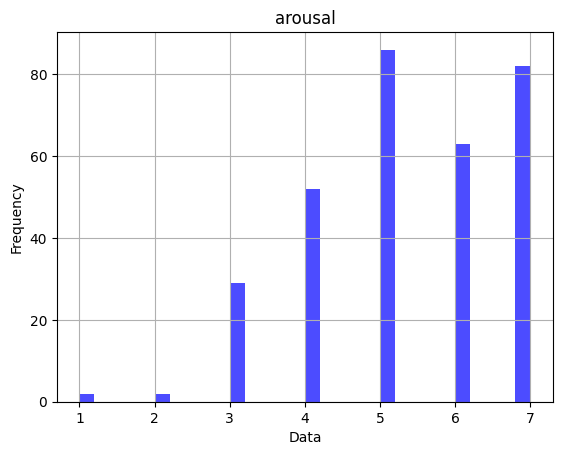

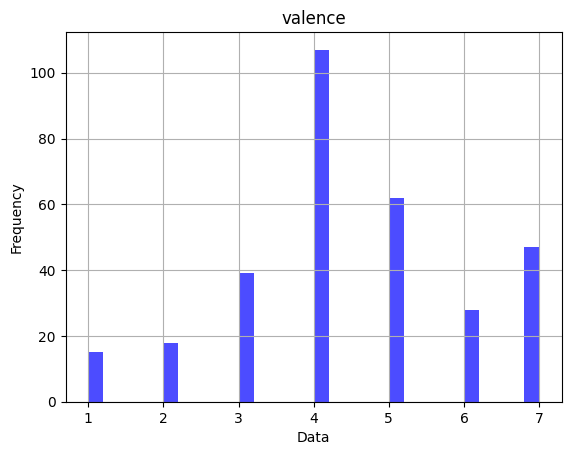

In [87]:

for i, label_type in enumerate(['arousal', 'valence']):
    fig = plot_distribution(vals[:, i], title=label_type)
    plt.show()

In [113]:
X.mean()

-1.89190248090318e-14

In [123]:
X, Y = ts, one_hot_encoder(labels[:, 0])
dataset = EpochsDataset((X, Y), savepath='../datasets/arousal_1', transform=transforms.zscore)

In [124]:
dataset.save('../data/arousal_1.pt')

In [125]:
X, Y = ts, one_hot_encoder(labels[:, 1])
dataset = EpochsDataset((X, Y), savepath='../datasets/valence_1', transform=transforms.zscore)

In [126]:
dataset.save('../data/valence_1.pt')